# Non-linear and non-affine problem

Contributed by: Diógenes Figueroa and Pablo Giuliani

In this subsection we explore an approach to obtain the effective dynamical equations for the reduced coordinates of a system in which the traditional Galerkin projection can't be done efficiently. This is the case for non-linear and non-affine systems, such as Skyrme-type Density Functional Theory (DFT). 

These "Black-Box Galerkin" emulators are an intermediate between the Galerkin-RBM emulator we built for the harmonic oscillator, and a full black-box dynamical system like SECAR. The idea here is that although we have the dynamical equations that govern the system, these equations are so complicated that even the Galerkin projection approach has trouble improving the timings as compared to the high-fidelity solvers. 

In this section we explore a toy model which exhibits the main challanges that one faces when attampting to use the Galerkin method for non-linear DFT. We model the $M$ wavefunctions as interacting through cumulative densities of all the nucleons, the Hamiltonian looks like:

$$
    \left(-\frac{d^2}{dx^2}+\kappa x^2+q \rho(x)^\alpha\right)\phi_i(x) = \lambda_i \phi_i(x)
$$

where $\displaystyle \rho(x) = \sum_{i}^M|\phi_i(r)|^2$ is the cumulative density, and the parameters are $\{\kappa,q,\alpha\}$. The main problem we face when trying to use the Galerkin projection method in this case is that the dependence on the parameter $\alpha$ is non-affine as well as non-linear, since $\rho$ explicitly depends on the solution. This reduces the time advantage provided by the emulators since the reduced equations cannot be precomputed and need to be done at runtime. 

For our illustrations in this subsection we will concentrate on two observables of interest, the total energy and the radius:

$$
E = \sum_{i=1}^M \lambda_i,
$$

$$
R = \int  dx\hskip0.1cmx^2 \rho(x)
$$

We will attempt at learning the reduced equations directly from high fidelity runs.

## First we load some high-fidelity solutions
In the interest of time we do not solve the high-fidelity equation here, a full comprehensive solution [can be found here](https://github.com/ascsn/nuclear-dimensionality-reduction-book/tree/main/nuclear-dr/blackbox_galerkin/ToyMdelData). All the high-fidelity solutions have been pre-computed and we simply load them. We also define all the discretized versions of the operators that compose the Hamiltonian.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_test  = pd.read_json("ToyMdelData/test.json")
df_train = pd.read_json("ToyMdelData/train.json")

In order to save some space the dataframes do not have the Hamiltonians themselves, for this reason we need to build the numerical Hamiltonians at runtime.

**Some helpers to build the Hamiltonians**

In [3]:
def generate_second_derivative_matrix(xgrid):
    N = len(xgrid)
    dx = xgrid[1]-xgrid[0]
    # Generate the matrix for the second derivative using a five-point stencil
    main_diag = np.ones(N) * (-5.0 /2 / dx**2)
    off_diag = np.ones(N - 1)* 4/3 / dx**2
    off_diag2 = np.ones(N - 2) * (-1.0 / (12 * dx**2))
    D2 = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1) + np.diag(off_diag2, k=2) + np.diag(off_diag2, k=-2)
    return D2

In [4]:
def harmonic_potential_matrix(xgrid):
    return np.diag(xgrid**2)

In [5]:
def self_interaction_potential(rho,alpha):
    return np.diag(rho**alpha)

In [6]:
def rho_maker(wf_list):
    sq_list=[wf**2 for wf in wf_list]
    return np.sum(sq_list, axis=0)

In [7]:
x_max = 15.0  # Maximum coordinate value for the grid
N_grid=300
x = np.linspace(-x_max, x_max, N_grid)
dx=x[1]-x[0]

D2=generate_second_derivative_matrix(x)
harmonic_matrix=harmonic_potential_matrix(x)

high_fid_hamil = lambda rho,alpha,kappa,q : -D2 + kappa*harmonic_matrix + q*self_interaction_potential(rho,alpha)   

Now we are ready to extend the dataframes to include the Hamiltonians

In [8]:
def extend_dataframe(df):
    ''' High fidelity Hamiltonian '''
    df['density']     = df.apply( lambda row : np.array(rho_maker([ np.array(row['wave_'+str(i)]) for i in range(5)])), axis=1 )
    df['hamiltonian'] = df.apply( lambda row : np.array(high_fid_hamil(row['density'],row['alpha'],row['kappa'],row['q'])),axis=1)

extend_dataframe(df_train)
extend_dataframe(df_test)

## Operator fitting: Frobenius norm fitting

We are now ready to discuss an implementation to fit the Galerkin equations themselves. The approach we take here is as follows:

- Compute some high-fidelity solutions.
- Perform PCA on the wavefunctions, here we are faced with an alternative: either we do all states at once or we do one emulator per state. We will present both.
- Project the Hamiltonian onto PC space.
- Minimize the [Frobenius norm](https://en.wikipedia.org/wiki/Matrix_norm) between some model for our operator and the numerical hamiltonian. The Frobenius norm is the generalization of the regular euclidian norm between vectors (or L2 norm in the case of functions).

Since all other points should be familiar by now we will concentrate on the last one. The model we will have for our Hamiltonian is a polynomial feature model on the parameters $\alpha_i$ of the data:

\begin{equation} 
\mathcal H_{ij} = (H_0)_{ij} + (H_1)^k_{ij}\alpha_k + (H_2)^{kl}_{ij}\alpha_k\alpha_l + (H_3)^{klm}_{ij} \alpha_k\alpha_l\alpha_m+\cdots 
\end{equation}

The minimization problem is then:

\begin{equation}
\min_{H_I}|| \mathcal H_{model} - \mathcal H_{data} ||_F
\end{equation}

It is important to note that in this approach the minimization problem factorizes into component-wise quadratic programming minimization porblems, which can be solved in parallel and analytically.

This model has the disadvantage that the number of parameters grows exponentially on the order that one wishes to use. Sparsity promoting approaches, such an L1 or [Lasso regularization](https://en.wikipedia.org/wiki/Lasso_(statistics)) is a good choice to deal with a situation where we have more coefficients than data values. Because we might be interested in allowing for high order polynomial features we also consider the LASSO regularized minimization problem:

\begin{equation}
\min_{H_I}|| \mathcal H_{model} - \mathcal H_{data} ||_F + \lambda ||\mathcal H_{model}||_1
\end{equation}

as a means to promote sparsity on the coefficients $H_I$.

### Now we are ready to write some code

We will be using [sklearn.liear_models.LinearRegression()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to solve the first optimization problem, and [sklearn.linear_models.LassoLarsCV()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLarsCV.html#sklearn.linear_model.LassoLarsCV) to solve the regularized problem.

In [9]:
class FitterNotImplemented(BaseException):
    pass

class Fitter:
    def __init__(self,**kwargs):
        self.hamiltonians = kwargs['hamiltonians']
        self.pars         = kwargs['pars']
        self.dim          = len(self.hamiltonians[0])
        self.nPars        = len(self.pars)
    
    def fit(self):
        NotImplemented
    
    def predict(self,pars):
        NotImplemented

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import *

class Sklearn(Fitter):
    
    ''' Sklearn fitter wrapper '''
    
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.ord    = kwargs["order"]
        self.fitter = None
        if kwargs['fitter']=="LeastSquares":
            self.fitter = LinearRegression()
        elif kwargs['fitter']=="Lasso":
            self.fitter = LassoLarsCV()
        else:
            raise FitterNotImplemented()
            
    def fit(self):
        ''' Allocate space for all the tensors H0, H1, H2, ... '''
        self.poly      = PolynomialFeatures(degree=self.ord)
        self.poly_feat = self.poly.fit_transform(self.pars)
        self.hs        = [ np.zeros((self.dim,self.dim)) for i in range(len(self.poly_feat[0]))]
        
        for j in range(self.dim):
            for k in range(self.dim):
                ''' We now build a new vector out of the features '''
                y_axis = [ self.hamiltonians[i][j,k] for i in range(self.nPars) ]
            
                self.fitter.fit(self.poly_feat,y_axis)
                
                ''' Sklearn stores the order zero under a different name '''
                self.hs[0][j,k] = self.fitter.intercept_
                
                ''' All others are together '''
                for i in range(1,len(self.poly_feat[0])):
                    self.hs[i][j,k] = self.fitter.coef_[i]
    
    def predict(self,pars):
        ''' Create the polynomial features of the data '''
        poly_feat = self.poly.fit_transform([pars])
        ''' Build the Hamiltonian '''
        hamiltonian = np.zeros((self.dim,self.dim))
        for i,h in enumerate(self.hs):
            hamiltonian += h*poly_feat[0][i]
        return hamiltonian

## Global Frobenius: One for All

We build a reduced Hamiltonian from which we expect to obtain all the wave functions at the same time.

![Fig1](FullH.png)


This is the main object which interfaces the high-fidelity data with the underlying fitters

In [11]:
class Frobenius:
    def __init__(self,**kwargs):
        self.waves  = kwargs['waves']
        self.hamils = kwargs['hamiltonian']
        self.pars   = kwargs['pars']
        
        self.nWaves = len(self.waves)
        self.nPars  = len(self.pars)
        
        self.u,self.s,self.v =  np.linalg.svd(np.vstack(self.waves)) 
        self.type            = np.float64
    
    def predict_all(self,pars):
        ''' Function to predict both eigenvalues and eigenfucntions '''
        return np.linalg.eigh(self.fitter.predict(pars))
    
    def predict_rsp(self,pars):
        ''' Predict wavefunctions in real, high-fidelity space '''
        evl,evc = self.predict_all(pars)
        waves = np.dot(evc[:,:self.dim],self.v[:self.dim])
        return waves[:self.nWaves]
    
    def predict_radius(self,pars):
        ''' Predict the radius '''
        rho = rho_maker(self.predict_rsp(pars))
        rho = rho[int(len(rho)/2):]
        R   = 0
        for i,val in enumerate(rho):
            R += rho[i] * i**2
        return R
    
    def predict_energy(self,pars):
        return np.sum(np.linalg.eigvalsh(self.fitter.predict(pars))[:self.nWaves])
    
    def build(self,**kwargs):
        
        self.dim    = kwargs['dimension']
        self.ord    = kwargs['order']
        
        ''' Fisrt we build the local basis '''
        self.basis = np.vstack( self.v[:self.dim]  )
        
        ''' We now build a reduced Hamiltonian to set as the target for minimization '''
        self.hamiltonians = []
        
        for i,pars in enumerate(self.pars):
            
            hamiltonian = np.zeros((self.dim,self.dim),self.type)
            
            ''' Project onto pc space '''
            hamiltonian = np.dot(np.array(self.basis),np.dot(self.hamils[i],np.array(self.basis).T))
            self.hamiltonians.append(hamiltonian)
            
        self.hamiltonians = np.array(self.hamiltonians)
        
        ''' Build the fitter '''
        self.fitter = Sklearn(hamiltonians = self.hamiltonians,
                              pars         = self.pars,
                              fitter       = kwargs['fitter'],
                              order        = self.ord)
        self.fitter.fit()

We also need some helpers to visialize the results

In [12]:
import matplotlib.pyplot as plt

def test_set(model,df,label):
    errors = [[] for i in range(model.nWaves)]
    for i,pars in enumerate(df[['alpha','kappa','q']].values):
        evl,evc = model.predict_all(pars)
        for j in range(model.nWaves):
            errors[j].append((evl[j]-df['eigenvalues'].values[i][j]))
    
    fig, ax = plt.subplots(dpi=200)
    fig.patch.set_facecolor('white')
    for j in range(model.nWaves):
        errors[j].sort( key = lambda item : -np.abs(item) )
        plt.semilogy(np.abs(errors[j]),label='E'+str(j)+": "+f'[{min(errors[j]):.1e},{max(errors[j]):.1e}]')
    plt.title(label+" set error")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Configuration #")
    plt.show()
    return errors

### Let's test these models

First we build them

In [13]:
frobenius = Frobenius(waves        = [ np.vstack(df_train['wave_'+str(i)]) for i in range(5) ],
                      hamiltonian  = df_train['hamiltonian'].values,
                      pars         = df_train[['alpha','kappa','q']].values)

In [14]:
dimension = 10
order     = 3
fitter    = "LeastSquares"

frobenius.build(dimension=dimension,order=order,fitter=fitter)

Now we test them

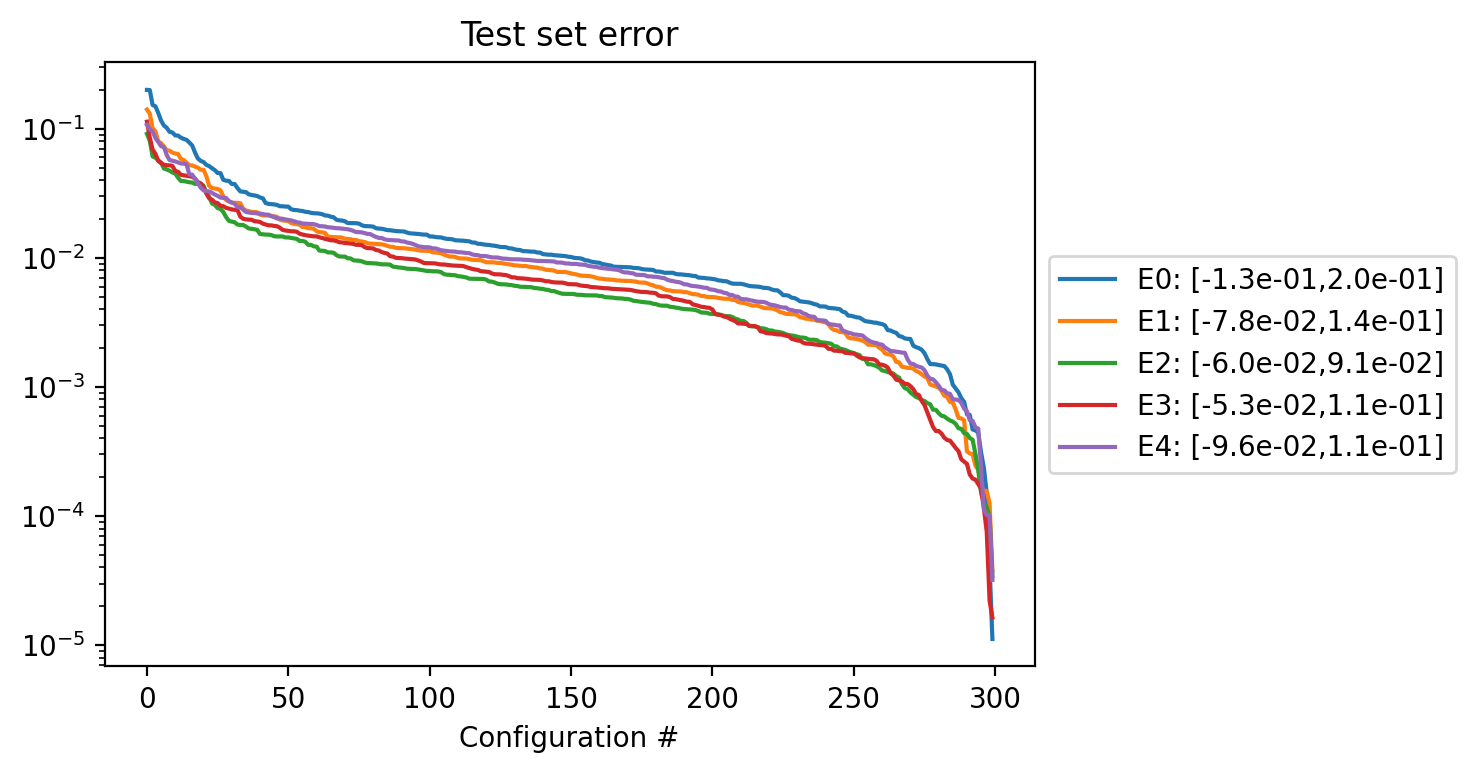

ValueError: too many values to unpack (expected 2)

In [15]:
error_test  = test_set(frobenius,df_test ,"Test" )
error_train = test_set(frobenius,df_train,"Train")

## Local Approach: One for Each

We build one Hamiltonian per wave function, interestingly this procedure basically decouples the problem!

![Fig2](HSingle.png)

This fitter is a special case of the prvious one, we simply add a wrapper to handle the correct splicing of the data into each of the underlying Frobenius fitters.

In [ ]:
class SequentialFrobenius:
    def __init__(self,**kwargs):
        self.waves     = kwargs['waves']
        self.pars      = kwargs['pars']
        self.hamil     = kwargs['hamiltonian']
        self.nWaves    = len(self.waves)
        
        ''' Splices the data and feeds it to several Frobenius '''
        self.emulators = [ Frobenius(waves=[wave],
                                     hamiltonian=self.hamil,
                                     pars=self.pars) for wave in self.waves ]
    
    def build(self,dimension,order,fitter):
        ''' Build each fitter '''
        for emul in self.emulators:
            emul.build(dimension = dimension,
                       order     = order,
                       fitter    = fitter)
            
    def predict_energy(self,pars):
        ''' Collect each prediction and add them all up '''
        evl = np.zeros(self.nWaves)
        for i,emul in enumerate(self.emulators):
            evl[i] = emul.predict_all(pars)[0][0]
        return sum(evl)
    
    def predict_all(self,pars):
        ''' Return all energies and wavefunctions '''
        res = [ emul.predict_all(pars) for emul in self.emulators ]
        energies = np.array([ sol[0][0] for sol in res ])
        waves    = np.array([ sol[1][0] for sol in res ])
        return energies,waves
    
    def predict_rsp(self,pars):
        ''' Returns the real space wavefunctions '''
        waves = [ emul.predict_rsp(pars)[0] for emul in self.emulators ]
        return np.array(waves)
    
    def predict_radius(self,pars):
        ''' Computes the radius '''
        rho = rho_maker(self.predict_rsp(pars))
        rho = rho[int(len(rho)/2):]
        R   = 0
        for i,val in enumerate(rho):
            R += rho[i] * i**2
        return R

We are ready to test these

In [ ]:
seq_frobenius = SequentialFrobenius(waves         = [ np.vstack(df_train['wave_'+str(i)]) for i in range(5) ],
                                    hamiltonian   = df_train['hamiltonian'],
                                    pars          = df_train[['alpha','kappa','q']].values)

Build them

In [ ]:
dimension = 3
order     = 6
fitter    = "Lasso"

seq_frobenius.build(dimension=dimension,order=order,fitter=fitter)

Display their errors

In [ ]:
seq_error_test  = test_set(seq_frobenius,df_test ,"Test" )
seq_error_train = test_set(seq_frobenius,df_train,"Train")

From these experiments we can conclude that this approach is capable of providing us with good approximations to the reduced equations which, unlike the usual Galerkin projecting equations, can be found once and for all. Many avenues and interesting ideas can be explored out of the ones here presented, such as a direct application to non-linear and non-affine Density Functional Theory.